In [1]:
import numpy as np
import pandas as pd
import random

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# Позволяет отображать в блокнотах графики matplotlib
%matplotlib inline 

In [3]:
matplotlib.rcParams.update({'font.size':14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
DS_TRAIN_ORIG_PATH = '../L10/train.csv'
DS_TRAIN_PREP_PATH = '../L10/train_prep.csv'
DS_SUBMIT_SAMPLE_PATH = '../L10/sample_submission.csv'
DS_SUBMIT_PATH = '../L10/submit_base.csv'
DS_TEST_ORIG_PATH = '../L10/test.csv'
DS_TEST_PREP_PATH = '../L10/test_prep.csv'

Описание датасета:

Id - идентификационный номер квартиры
DistrictId - идентификационный номер района - категория
Rooms - количество комнат
Square - площадь
LifeSquare - жилая площадь
KitchenSquare - площадь кухни
Floor - этаж                    - категория
HouseFloor - количество этажей в доме   
HouseYear - год постройки дома   
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
Social_1, Social_2, Social_3 - социальные показатели местности
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
Price - цена квартиры

## Программирование обработки данных

In [7]:
square_valid_min = 16
square_valid_max = 280
priceSQM_valid_max = 8000
priceSQM_valid_min = 800
min_obj_num_in_group = 5
rooms_valid_max = 5
rooms_valid_min = 1
one_room_square_valid_max = 50

In [8]:
class DataPreprocessing:
    
    def __init__(self):
        self.medians = None
        self.kitchen_square_quantile = None
        self.median_room_square = None
        self.median_price_sqm = None
        self.df_med_RoomSquare_by_DI_HY = None
        self.df_med_RoomSquare_by_HY = None
        #self.col_for_HC1 = None
        self.target_HC1 = None
        #self.df_train_HC1 = None
        #self.X_train_HC1 = None
        #self.X_train_HC1 = None
        #self.X_test_HC1 = None
        self.scaler_HC1 = None
        self.clf_HC1 = None       
        self.col_for_scale_HC1 = None
        self.df_test_HC1 = None
        self.df_test_HC1_scaled = None
        self.y_pred_HC1 = None

    def fit(self, X):
        X = X.copy()
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        self.df_med_RoomSquare_by_DI_HY = X.loc[(X['Square'] > square_valid_min) & \
                                          (X['Square'] < square_valid_max) & \
                                          (X['Rooms'] > 0)]\
                                          .groupby(['DistrictId', 'HouseYear'], as_index=False).apply(self.med_room_square)
 
        self.df_med_RoomSquare_by_DI_HY.rename(columns={'mean_room_square':'mean_room_square_by_DI_HY',\
                                        'median_room_square':'median_room_square_by_DI_HY',\
                                        'obj_num':'obj_num_by_DI_HY',\
                                        'median_PriceSQM':'median_PriceSQM_by_DI_HY'}, inplace=True) 
        
        self.df_med_RoomSquare_by_HY = X.loc[(X['Square'] > square_valid_min) & \
                                          (X['Square'] < square_valid_max) & \
                                          (X['Rooms'] > 0)
                                            ].groupby(['HouseYear'], as_index=False).apply(self.med_room_square)

        self.df_med_RoomSquare_by_HY.rename(columns={'mean_room_square':'mean_room_square_by_HY',\
                                        'median_room_square':'median_room_square_by_HY',\
                                        'obj_num':'obj_num_by_HY',\
                                        'median_PriceSQM':'median_PriceSQM_by_HY'}, inplace=True) 
        
        self.median_room_square = (X['Square'] / X['Rooms']).median()
        self.median_price_sqm = X['PriceSQM'].median()

        # подстрахуемся
        self.df_med_RoomSquare_by_DI_HY.loc[self.df_med_RoomSquare_by_DI_HY['median_room_square_by_DI_HY'] == np.inf,\
                                            'median_room_square_by_DI_HY'] = self.median_room_square
        
        # HC_1 restore
        col_for_HC1 = ['Social_1', 'Social_2', 'Social_3', 'Helthcare_2','Healthcare_1']
        self.target_HC1 = 'Healthcare_1'
        df_train_HC1 = X[col_for_HC1].copy()
        df_train_HC1[self.target_HC1] = df_train_HC1[self.target_HC1].fillna(9999).astype('int')
        
        y_train_HC1 = df_train_HC1.loc[(df_train_HC1[self.target_HC1] != 9999), self.target_HC1]
        X_train_HC1 = df_train_HC1.loc[(df_train_HC1[self.target_HC1] != 9999)].drop(self.target_HC1, axis=1)
        
        #X_test_HC1 = df_train_HC1.loc[(df_train_HC1[self.target_HC1] == 9999)].drop(self.target_HC1, axis=1)
        self.scaler_HC1 = RobustScaler()
        
        self.col_for_scale_HC1 = ['Social_1', 'Social_2', 'Social_3', 'Helthcare_2']
        X_train_HC1[self.col_for_scale_HC1] = self.scaler_HC1.fit_transform(X_train_HC1[self.col_for_scale_HC1])
        y_train_HC1 = y_train_HC1.values
        # применим метод KNN для восстановления HC_1
        # опытным путем было установлено, что наилучше результаты даеет параметр n_neighbors=2.
        self.clf_HC1 = KNeighborsClassifier(n_neighbors=2)
        self.clf_HC1.fit(X_train_HC1, y_train_HC1)
        
    def transform(self, X, y=None):
        
        # Square restore        
        l = ['mean_room_square_by_DI_HY', 'median_room_square_by_DI_HY', 'obj_num_by_DI_HY', 'median_PriceSQM_by_DI_HY',\
             'mean_room_square_by_HY', 'median_room_square_by_HY', 'obj_num_by_HY', 'median_PriceSQM_by_HY',\
             'Square_restored']
        for i in l:
            if i in X.columns:
                X.drop(i, axis=1, inplace=True)
        
        X = X.merge(self.df_med_RoomSquare_by_DI_HY, on=['DistrictId', 'HouseYear'], how='left')
        X = X.merge(self.df_med_RoomSquare_by_HY, on=['HouseYear'], how='left')

        # если в рабочих данных есть объекты, которых не было в тренировочных по году и/или району заполним количество нулями
        X.loc[X['median_room_square_by_HY'].isna(),'obj_num_by_HY'] = 0
        X.loc[X['median_room_square_by_DI_HY'].isna(), 'obj_num_by_DI_HY'] = 0

        # если в рабочем датасете не было данных, которые были в тренировочном заполним  медианой
        X.loc[X['median_room_square_by_HY'].isna(), 'median_room_square_by_HY'] = self.median_room_square
        X.loc[X['median_PriceSQM_by_HY'].isna(), 'median_PriceSQM_by_HY'] = self.median_price_sqm

        # если в датасете не было данных по району, году, заполним медианными данными по году
        X.loc[X['median_room_square_by_DI_HY'].isna(), 'median_PriceSQM_by_DI_HY'] = \
                                   X.loc[X['median_room_square_by_DI_HY'].isna(), 'median_PriceSQM_by_HY']

        X.loc[X['median_room_square_by_DI_HY'].isna(), 'median_room_square_by_DI_HY'] = \
                                   X.loc[X['median_room_square_by_DI_HY'].isna(), 'median_room_square_by_HY']
        
        
        #median_PriceSQM_by_HY self.median_price_sqm
        #median_PriceSQM_by_DI_HY
        #median_room_square_by_DI_HY
        
        X['Square_restored'] = 0
        
        # Т.к. модель работает ценой м.кв. нужно постараться хорошо обработать выбросы по полощади.
        # Выбросами считаем S < 16 B S > 280.
        # S < 20 S<LS - кривая and S  PriceSQM > 8000 Room > 0 - восстанавливаем по Room * (df_med_RoomSquare_by_DI_HY or df_med_RoomSquare_by_HY

        X['Square_r'] = 0 # создадим колонку, куда будем записывать восстанавливаемую площадь.
        
        # если площадь маленькая и содержит ошибку неадекватная, восстановим площадь через среднюю площадь комнаты и число комнтат
        cond_1= (X['Square'] < square_valid_min) & ((X['Square'] < X['LifeSquare']) | (1==1)) & (X['Rooms'] > 0)

        # сначала заполним S для объектов с кривой площадью
        X.loc[cond_1 & (X['obj_num_by_DI_HY'] >= min_obj_num_in_group), 'Square_r'] = \
                X.loc[cond_1 & (X['obj_num_by_DI_HY'] >= min_obj_num_in_group), 'Rooms'] * \
                X.loc[cond_1 & (X['obj_num_by_DI_HY'] >= min_obj_num_in_group), 'median_room_square_by_DI_HY']

        # если не нашлсь комбинации района и города посчитаем среднюю площадь по году постройки
        X.loc[(cond_1) & (X['obj_num_by_DI_HY'] < min_obj_num_in_group), 'Square_r'] = \
                X.loc[(cond_1) & (X['obj_num_by_DI_HY'] < min_obj_num_in_group), 'Rooms'] * \
                X.loc[(cond_1) & (X['obj_num_by_DI_HY'] < min_obj_num_in_group), 'median_room_square_by_HY']

        # если вдруг еще остались объекты 
        X.loc[(cond_1) & (X['Square_r'] == 0), 'Square_r'] = \
        X.loc[(cond_1) & (X['Square_r'] == 0), 'Rooms'] * self.median_room_square

        X.loc[cond_1, 'Square_restored'] = 1
    
        # если площадь маленькая и возможно правильная умножим на 10, возможно это опечатка  -- перенести
        cond_2 = (X['Square'] < square_valid_min) & ((X['Square'] < X['LifeSquare']) | (1==1)) 
        X.loc[(cond_2) & (X['Square_r'] == 0), 'Square_r'] = X.loc[(cond_2) & (X['Square_r'] == 0), 'Square'] * 10
        X.loc[cond_2, 'Square_restored'] = 1

        # если площадь слишком большая разделим на 10 возможно это опечатка.
        cond_3 =(X['Square'] > square_valid_max)
        X.loc[(cond_3) & (X['Square_r'] == 0), 'Square_r'] = X.loc[(cond_3) & (X['Square_r'] == 0), 'Square'] / 10
        X.loc[cond_3, 'Square_restored'] = 1

        # пересчитаем PriceSQM
        if 'Price' in X.columns:
            X.loc[X['Square_restored'] == 1, 'PriceSQM'] = X.loc[X['Square_restored'] == 1,'Price'] \
                         / X.loc[X['Square_restored'] == 1, 'Square_r']
        # перенесем Square_r в Square
        X.loc[X['Square_restored'] == 1, 'Square'] = X.loc[X['Square_restored'] == 1, 'Square_r']
        
        ## Rooms
        # восстанавливаем количество комнат где 0 и больше 5 через среднюю площадь комнаты по району, году постройки. В несколько этапов.
        X['Rooms_outlier'] = 0
        cond_4 = (X['Rooms'] < rooms_valid_min) | (X['Rooms'] > rooms_valid_max)
        X.loc[cond_4, 'Rooms'] = (X.loc[cond_4, 'Square'] / X.loc[cond_4, 'median_room_square_by_DI_HY']).round(0)
        X.loc[cond_4, 'Rooms_outlier'] = 1
        # уточним площади однокомнатных квартир, где площади, приходящиеся на комнату больше 50 кв.м
        cond_5 = (X['Rooms'] == rooms_valid_min) & (X['Square'] > one_room_square_valid_max)
        X.loc[cond_5, 'Rooms'] = (X.loc[cond_5, 'Square'] / \
                                 np.where(X.loc[cond_5, 'obj_num_by_DI_HY'] >= min_obj_num_in_group, \
                                          X.loc[cond_5, 'median_room_square_by_DI_HY'],
                                          X.loc[cond_5, 'median_room_square_by_HY'])).round(0)
        X.loc[cond_5, 'Rooms_outlier'] = 1
        
        ## KitchenSquare
        conditition_ks = (X['KitchenSquare'].isna()) \
                 | (X['KitchenSquare'] > self.kitchen_square_quantile)
        X.loc[conditition_ks, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        ## HouseFloor, Floor
        
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] < X['Floor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians["HouseFloor"]
        
        floor_more_hfloor_i = X.loc[X['HouseFloor'] < X['Floor']].index
        
        X.loc[floor_more_hfloor_i, 'Floor'] = X.loc[floor_more_hfloor_i, 'HouseFloor'].apply(lambda x: 1 if x == 1 else random.randint(1, x))
        
        ## HouseYear
        current_year = datetime.now().year
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year

        ## Healthcare_1
        #if 'Healthcare_1' in X.columns:
        #    X.drop('Healthcare_1', axis=1, inplace=True)
        
        ## LifeSquare
        X['LifeSquare_restored'] = 0
        X['LifeSquare_part'] = (X['LifeSquare'] / X['Square']).round(2)
        X['LifeSquare_part'].fillna(0, inplace=True )
        
        # попробуем восстановить недаекватную жилую площадь для 1к квартир доля LS 0.55+-0.15
        cond_lsn_1 = (X['Rooms'] == 1) & (~X['LifeSquare_part'].between(0.4, 0.7))
        X.loc[cond_lsn_1, 'LifeSquare'] = X.loc[cond_lsn_1, 'Square'] *\
                                  np.clip(np.random.normal(0.55, 0.08), a_min=0.3, a_max=0.85)

        cond_lsn_2 = (X['Rooms'] == 2) & (~X['LifeSquare_part'].between(0.45, 0.75))
        X.loc[cond_lsn_2, 'LifeSquare'] = X.loc[cond_lsn_2, 'Square'] * \
                                  np.clip(np.random.normal(0.6, 0.04), a_min=0.3, a_max=0.8)
        
        cond_lsn_3 = (X['Rooms'] == 3) & (~X['LifeSquare_part'].between(0.47, 0.77))
        X.loc[cond_lsn_3, 'LifeSquare'] = X.loc[cond_lsn_3, 'Square'] * \
                                  np.clip(np.random.normal(0.62, 0.08), a_min=0.32, a_max=0.85)
        
        cond_lsn_4 = (X['Rooms'] == 4) & (~X['LifeSquare_part'].between(0.5, 0.8))
        X.loc[cond_lsn_4, 'LifeSquare'] = X.loc[cond_lsn_4, 'Square'] * \
                                  np.clip(np.random.normal(0.65, 0.04), a_min=0.35, a_max=0.9)
        
        cond_lsn_5 = (X['Rooms'] >=5) & (~X['LifeSquare_part'].between(0.5, 0.8))
        X.loc[cond_lsn_5, 'LifeSquare'] = X.loc[cond_lsn_5, 'Square'] * \
                                  np.clip(np.random.normal(0.65, 0.08), a_min=0.35, a_max=0.9)

        X.loc[cond_lsn_1 | cond_lsn_2 | cond_lsn_3 | cond_lsn_4 | cond_lsn_5, 'LifeSquare_restored'] = 1
        
        X.loc[X['LifeSquare_restored'] == 1, 'LifeSquare_part'] = \
                        (X.loc[X['LifeSquare_restored'] == 1, 'LifeSquare'] \
                        / X.loc[X['LifeSquare_restored'] == 1, 'Square']).round(2)
        
        
        self.df_test_HC1 = X.loc[X[self.target_HC1].isna()][self.col_for_scale_HC1].copy()
        self.df_test_HC1_scaled = \
            pd.DataFrame(self.scaler_HC1.transform(self.df_test_HC1[self.col_for_scale_HC1]), columns=self.col_for_scale_HC1)
        self.y_pred_HC1 = self.clf_HC1.predict(self.df_test_HC1_scaled)      
        self.df_test_HC1['Healthcare_1_pred'] = self.y_pred_HC1
        self.df_test_HC1.drop(self.col_for_scale_HC1, axis=1, inplace=True)
        X = X.merge(self.df_test_HC1, left_index=True, right_index=True, how='left')
        cond_HC1_1 = X['Healthcare_1'].isna()
        X.loc[cond_HC1_1, 'Healthcare_1'] = X.loc[cond_HC1_1, 'Healthcare_1_pred']
        X['Healthcare_1_pred'] = 0
        X.loc[~cond_HC1_1,'Healthcare_1_pred'] = 1

        # Заполнение пропусков это конечно приемлемо для учебной модели,
        # но для реальной модели нужно определить поля обязательные  поля, без которых модель
        ## не может работать. Иначе можно запостить запрос без данных и получить какой то ответ, что тоже не есть хорошо.
        X.fillna(self.medians, inplace=True)
        
        return X
    
    def med_room_square(self, x):
        result = {
        'mean_room_square':x['Square'].sum() / x['Rooms'].sum(),
        'median_room_square':(x['Square'] / x['Rooms']).median(),
        'obj_num':x['Id'].count(),
        'median_PriceSQM':x['PriceSQM'].median()
        }
        return pd.Series(result).round(2)


In [9]:
class FeatureGenerator():
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.median_price_by_district = None
        self.median_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        self.median_price_by_district_median = None
        self.median_price_by_floor_year_median = None
        self.median_price_by_HA = None
        self.median_price_by_HA_median = None
        
    def fit(self, X, y=None):
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = binary_to_numbers = {'A' : 0, 'B' : 1}
        
        #DistrictId
        self.district_size = X['DistrictId'].value_counts().reset_index().\
            rename(columns = {'index':'DistrictId','DistrictId':'DistrictSize'})
        
        #TargetEncoding
        ## District, rooms
        df = X.copy()
        
        if y is not None:
            df['PriceSQM'] = y.values
            
            self.median_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'PriceSQM':'median'})\
                     .rename(columns={'PriceSQM':'MedPriceSQM_ByDistrict'})
            
            self.median_price_by_district_median = self.median_price_by_district['MedPriceSQM_ByDistrict'].median()
        
        #Floor, Year
        self.floor_max = df['Floor'].max()
        self.house_year_max = df['HouseYear'].max()
        df['House_age'] = 2021 - df['HouseYear'] 

        if y is not None:
            df = self.floor_to_cat_pandas(df)
            df = self.year_to_cat_pandas(df)
            self.median_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'PriceSQM':'median'}).\
               rename(columns={'PriceSQM':'MedPriceSQM_ByFloorYear'})
            self.median_price_by_floor_year_median = self.median_price_by_floor_year['MedPriceSQM_ByFloorYear'].median()

            
        if y is not None:
            df = self.House_age_to_cat_pandas(df)
            self.median_price_by_HA = df.groupby(['House_age'], as_index=False).agg({'PriceSQM':'median'})\
                     .rename(columns={'PriceSQM':'MedPriceSQM_by_HA'})
            self.median_price_by_HA_median = self.median_price_by_HA['MedPriceSQM_by_HA'].median()


    def transform(self, X):

        # проведем эксперимент, прологарифмируем площадь
        X['Square_log'] = np.log(X['Square'])
        
        #Binary features
        X['Ecology_2'] = X['Ecology_2'].replace(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].replace(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].replace(self.binary_to_numbers)
        
        #District
        
        if 'DistrictSize' in X.columns:
            X.drop('DistrictSize', axis=1, inplace=True)
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        
        if 'NewDistrict' in X.columns:
            X.drop('NewDistrict', axis=1, inplace=True)
        X['NewDistrict'] = 0
        X.loc[X['DistrictSize'].isna(), 'NewDistrict'] = 1
        X['DistrictSize'].fillna(5, inplace=True)
        
        if 'DistrictLarge' in X.columns:
            X.drop('DistrictLarge', axis=1, inplace=True)
        X['DistrictLarge'] = ((X['DistrictSize'] > 100) * 1).astype(int)
        
        X['House_age'] = 2021 - X['HouseYear'] 
        
        X = self.floor_to_cat_pandas(X)
        X = self.year_to_cat_pandas(X)
        X = self.House_age_to_cat_pandas(X)
        X = self.House_year_to_cat_pandas(X)
        
        if self.median_price_by_district is not None:
            if 'MedPriceSQM_ByDistrict' in X.columns:
                X.drop('MedPriceSQM_ByDistrict', axis=1, inplace=True)
            X = X.merge(self.median_price_by_district, on=['DistrictId','Rooms'], how='left')
            X['MedPriceSQM_ByDistrict'].fillna(self.median_price_by_district_median, inplace=True)
        
        if self.median_price_by_floor_year is not None:
            if 'MedPriceSQM_ByFloorYear' in df_train.columns:
                X.drop('MedPriceSQM_ByFloorYear', axis=1, inplace=True)
            X = X.merge(self.median_price_by_floor_year, on=['year_cat','floor_cat'], how='left')
            X['MedPriceSQM_ByFloorYear'].fillna(self.median_price_by_district_median, inplace=True)
            
        if self.median_price_by_HA is not None:
            if 'MedPriceSQM_by_HA' in df_train.columns:
                X.drop('MedPriceSQM_by_HA', axis=1, inplace=True)
            X = X.merge(self.median_price_by_HA, on=['House_age'], how='left')
            X['MedPriceSQM_by_HA'].fillna(self.median_price_by_HA_median, inplace=True)
   
            
        return X
        
        
    def floor_to_cat_pandas(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        if 'floor_cat' in X.columns:
            X.drop('floor_cat', axis=1, inplace=True)
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
        X['floor_cat'].fillna(-1, inplace=True)
        return X

    def year_to_cat_pandas(self, X):
        bins = [0, 1941, 1945, 1980, 2010, self.house_year_max]
        if 'year_cat' in X.columns:
            X.drop('year_cat', axis=1, inplace=True)
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
        X['year_cat'].fillna(-1, inplace=True)
        return X
    
    def House_year_to_cat_pandas(self, X):
        bins = [0, 1930, 1950, 1960, 1970, 1980, 1995, 2010, X['HouseYear'].max()]
        if 'House_year_cat' in X.columns:
            X.drop('House_year_cat', axis=1, inplace=True)
        X['House_year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
        X['House_year_cat'].fillna(-1, inplace=True)
        return X
    
    def House_age_to_cat_pandas(self, X):
        bins = [0, 5, 10, 20, 30, 40, 50, 70, 90, X['House_age'].max()]
        if 'House_age_cat' in X.columns:
            X.drop('House_age_cat', axis=1, inplace=True)
        X['House_age_cat'] = pd.cut(X['House_age'], bins=bins, labels=False)
        X['House_age_cat'].fillna(-1, inplace=True)
        return X


## Отбор признаков

In [10]:
feature_names = [
                 'DistrictId', # потом убрать
                 'Rooms',
#                 'Square',     # потом убрать
                 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1',
                 'Ecology_2',
                 'Healthcare_1',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3','Helthcare_2',
                 'Shops_1', 'Shops_2']

target_name = 'Price'

In [11]:
new_feafure_names = [
        'median_room_square_by_DI_HY',
#        'obj_num_by_DI_HY',
#        'median_PriceSQM_by_DI_HY',
#        'Square_restored',
#        'Rooms_outlier',
#        'HouseFloor_outlier', 
#        'HouseYear_outlier',
#        'LifeSquare_nan',  # нет в этой модели
        'LifeSquare_restored', 
        'LifeSquare_part',
#        'Healthcare_1_pred',
#        'DistrictSize',
        'House_age',
#        'House_age_cat',
#        'floor_cat',
#        'year_cat',
#        'MedPriceSQM_ByDistrict',
        'House_year_cat', 'MedPriceSQM_ByFloorYear',
        'MedPriceSQM_by_HA',
        'Square_log']

## Разбиение на train и nest

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
df_train = pd.read_csv(DS_TRAIN_ORIG_PATH, sep=',')
df_test = pd.read_csv(DS_TEST_ORIG_PATH, sep=',')

In [14]:
y = df_train[target_name]

In [15]:
if 'PriceSQM' in df_train.columns:
    df_train.drop('PriceSQM', axis=1, inplace=True)
df_train['PriceSQM'] = df_train['Price'] / df_train['Square']

In [16]:
# если препроцессинг (восстановление признаков) делать после разделения на train и vaid
# то модели не хватает данных для обучения.
prepr = DataPreprocessing()

In [17]:
prepr.fit(df_train)
df_train = prepr.transform(df_train)

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train, y, test_size=0.33, shuffle=True, random_state=21)

In [19]:
# это нужно для тренировки модели
#if 'PriceSQM' in X_train.columns:
#    X_train.drop('PriceSQM', axis=1, inplace=True)
#X_train['PriceSQM'] = X_train['Price'] / X_train['Square']

In [20]:
#prepr = DataPreprocessing()

In [21]:
#prepr.fit(X_train)

In [22]:
#X_train = prepr.transform(X_train)

In [23]:
#X_valid = prepr.transform(X_valid)

In [24]:
y_train_sqm = X_train['Price'] / X_train['Square']
y_valid_sqm = X_valid['Price'] / X_valid['Square']

In [25]:
df_test = prepr.transform(df_test)

In [26]:
#y = df_train[target_name]
#X = df_train #.drop(columns=target_name)

In [27]:
y_train = X_train['Price']
y_valid = X_valid['Price']

In [28]:
#X_train, X_valid, y_train, y_valid = train_test_split(X, test_size=0.33, shuffle=True, random_state=21)

In [29]:
# y_train_sqm = np.clip(y_train_sqm, a_min=800, a_max=8000)
# y_valid_sqm = np.clip(y_valid_sqm, a_min=800, a_max=8000)

In [30]:
#if 'PriceSQM' in X_valid.columns:
#    X_valid.drop('PriceSQM', axis=1, inplace=True)
#X_valid['PriceSQM'] = y_valid_sqm.values
X_train.shape, y_train_sqm.values.shape, y_train.values.shape

((6700, 37), (6700,), (6700,))

In [31]:
#X_train.info()
#X_valid.info()
#df_test.info()
#prepr.df_med_RoomSquare_by_DI_HY

In [32]:
type(X_train)

pandas.core.frame.DataFrame

In [33]:
print(type(y_train))
print(type(y_train.values))
print(type(y_train_sqm))
print(type(X_train['Square']))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [34]:
y_train.count(), X_train['Square'].count(), y_train_sqm.count()

(6700, 6700, 6700)

In [35]:
#X_train.loc[X_train['Rooms'] == 7]
#X_train.describe()

In [36]:
X_train.sort_values(by='PriceSQM', ascending=False)[[ 'Rooms', 'Square', 'HouseYear', 'PriceSQM', 'Price']].head(30)

,Rooms,Square,HouseYear,PriceSQM,Price
2783,2.0,42.353485,1933,11854.652892,502085.860162
753,1.0,33.521641,2015,11393.003236,381912.162109
9961,1.0,34.911269,1955,11386.831424,397528.736061
2093,2.0,47.489415,1918,11328.412026,537979.657509
1068,1.0,46.248238,1977,11164.009578,516315.770611
9826,2.0,58.757047,2004,10648.571986,625678.644994
8501,2.0,17.414181,1977,10379.498777,180750.471749
651,3.0,54.036554,2017,10290.327151,556053.820499
4800,1.0,48.610000,1977,9942.059002,483283.488083
6074,2.0,55.637752,1958,9930.586635,552515.519533


In [37]:
#df_test = prepr.transform(df_test)

In [38]:
#Убедимся, что все прошло благополучно, полученные датасеты имеют одинаковый размер
# будет разная размерность у тренировочного и тестового датасета.
X_train.shape, X_valid.shape, df_test.shape

((6700, 37), (3300, 37), (5000, 35))

In [39]:
#X_train.info()

In [40]:
#Проверим в какое значение установились свойства класса после обучения
prepr.kitchen_square_quantile

13.0

In [41]:
y_train_sqm

9239    3159.410326
6930    2373.230546
8136    2476.799680
3424    3281.365132
6518    2337.773090
           ...     
9336    4132.423182
48      4013.749937
8964    4361.722365
5944    3119.087491
5327    3902.843205
Length: 6700, dtype: float64

In [42]:
features_gen = FeatureGenerator()

In [43]:
features_gen.fit(X_train, y_train_sqm)

In [44]:
features_gen.median_price_by_HA_median

4401.4677647229455

In [45]:
X_train = features_gen.transform(X_train)

In [46]:
#X_train.to_excel('..\L10\X_train_prep_1.xls', index=True)
#pd.DataFrame(y_train_sqm.values, columns=['PriceSQM']).to_excel('..\L10\y_train_sqm_prep_1.xls', index=True)

In [47]:
X_valid = features_gen.transform(X_valid)
df_test = features_gen.transform(df_test)

In [48]:
# в оригинальной задаче 29 призаков, у меня 27?
X_train.shape, X_valid.shape, df_test.shape

((6700, 49), (3300, 49), (5000, 47))

In [49]:
#from sklearn.feature_extraction import FeatureHasher
#df_district = pd.DataFrame(df_train['DistrictId'].unique(),columns=['DistrictId']).copy()
##df_district['DistrictId'] = df_district['DistrictId'].astype('str')
#hashing=FeatureHasher(input_type='string', n_features=10)
#df_district_hash = pd.DataFrame(hashing.transform(df_district['DistrictId'].astype('str')).toarray())
#for c in df_district_hash.columns:
#    df_district_hash.rename(columns={c:'DistrId_'+str(c)}, inplace=True)
#df_district_hash = pd.concat([df_district, df_district_hash], axis=1)
#feature_distr = ['DistrId_0', 'DistrId_1', 'DistrId_2', 'DistrId_3', 'DistrId_4', 'DistrId_5', 'DistrId_6', 
#                 'DistrId_7', 'DistrId_8', 'DistrId_9']
#X_train_dsh = X_train.merge(df_district_hash, on='DistrictId', how='left')

In [50]:
#df_district_hash.sort_values(by='DistrictId').head(60)
#df_district_hash.info()

In [51]:
#if 'DistrId_0' in X_train:
#    X_train_h.drop(feature_distr, axis=1, inplace=True)
#X_train = X_train.merge(df_district_hash, on='DistrictId', how='left')

In [52]:
#if 'DistrId_0' in X_valid:
#    X_valid_h.drop(feature_distr, axis=1, inplace=True)
#X_valid = X_valid.merge(df_district_hash, on='DistrictId', how='left')

In [53]:
#if 'DistrId_0' in df_test:
#    df_test.drop(feature_distr, axis=1, inplace=True)
#df_test = df_test.merge(df_district_hash, on='DistrictId', how='left')

In [54]:
# проверим сколько уникальных значений в массиве 
features_gen.median_price_by_district['MedPriceSQM_ByDistrict'].nunique()

624

In [55]:
X_train_for_model = X_train[feature_names + new_feafure_names] # + feature_distr]
X_train_for_model.shape

(6700, 25)

In [56]:
X_valid_for_model = X_valid[feature_names + new_feafure_names] # + feature_distr]
X_valid_for_model.shape

(3300, 25)

In [57]:
df_test_for_model = df_test[feature_names + new_feafure_names] # + feature_distr]
df_test_for_model.shape

(5000, 25)

In [58]:
X_train_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6700 entries, 0 to 6699
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   DistrictId                   6700 non-null   int64  
 1   Rooms                        6700 non-null   float64
 2   LifeSquare                   6700 non-null   float64
 3   KitchenSquare                6700 non-null   float64
 4   Floor                        6700 non-null   int64  
 5   HouseFloor                   6700 non-null   float64
 6   HouseYear                    6700 non-null   int64  
 7   Ecology_1                    6700 non-null   float64
 8   Ecology_2                    6700 non-null   int64  
 9   Healthcare_1                 6700 non-null   float64
 10  Ecology_3                    6700 non-null   int64  
 11  Social_1                     6700 non-null   int64  
 12  Social_2                     6700 non-null   int64  
 13  Social_3          

In [59]:
X_train_for_model.isna().sum().sum(), X_valid_for_model.isna().sum().sum(), df_test_for_model.isna().sum().sum()

(0, 0, 0)

In [60]:
#pd.concat([pd.concat([X_train, pd.DataFrame(y_train_sqm.values, columns=['PriceSQM'])], axis=1), pd.DataFrame(y_train.values, columns=['Price'])], axis=1).to_excel('../L10/t_26.xls', index=False)

## Построение модели

In [61]:
# Поиск по сетке не очень эффективная штука, т.к. может показать на валидационном датасете больший результат а на боевом меньший
# Почем такое происходит?

In [62]:
#model = RandomForestRegressor(max_depth=7, min_samples_leaf=50 ,random_state=21, criterion='mse', n_estimators=2000)
#model.fit(X_train_for_model, y_train_sqm)
#model.fit(X_train_for_model, y_train)

In [63]:
# Подсмотрел решение на kaggle 
model = GradientBoostingRegressor(criterion='mse', max_depth=6, min_samples_leaf=50, random_state=21, n_estimators=2250, 
                                     max_features='sqrt', loss='huber', learning_rate=0.025)

model.fit(X_train_for_model, y_train)


GradientBoostingRegressor(criterion='mse', learning_rate=0.025, loss='huber',
                          max_depth=6, max_features='sqrt', min_samples_leaf=50,
                          n_estimators=2250, random_state=21)

Оценка модели

In [64]:
#model = gb_model

In [65]:
#y_train_sqm_preds = rf_model.predict(X_train_for_model)
#y_train_sqm_preds = gb_model.predict(X_train_for_model)
y_train_preds = model.predict(X_train_for_model)

In [66]:
#y_valid_sqm_preds = rf_model.predict(X_valid_for_model)
#y_valid_sqm_preds = gb_model.predict(X_valid_for_model)
y_valid_preds = model.predict(X_valid_for_model)

In [67]:
#pd.concat([pd.concat([pd.concat([X_train, pd.DataFrame(y_train_sqm.values, columns=['PriceSQM'])], axis=1), pd.DataFrame(y_train_sqm_preds, columns=['PriceSQM_preds']) ], axis=1), pd.DataFrame(y_train.values, columns=['Price'])], axis=1).to_csv(DS_TRAIN_PREP_PATH, index=False)
#pd.concat([pd.concat([pd.concat([X_train, pd.DataFrame(y_train_sqm.values, columns=['PriceSQM'])], axis=1), pd.DataFrame(y_train_sqm_preds, columns=['PriceSQM_preds']) ], axis=1), pd.DataFrame(y_train.values, columns=['Price'])], axis=1).to_excel('..\L10\X_train_prep.xls', index=True)
#pd.concat([pd.concat([pd.concat([X_valid, pd.DataFrame(y_valid_sqm.values, columns=['PriceSQM'])], axis=1), pd.DataFrame(y_valid_sqm_preds, columns=['PriceSQM_preds']) ], axis=1), pd.DataFrame(y_valid.values, columns=['Price'])], axis=1).to_excel('..\L10\X_valid_prep.xls', index=True)

In [68]:
#y_train_preds = y_train_sqm_preds * X_train_for_model['Square'].values
#y_valid_preds = y_valid_sqm_preds * X_valid_for_model['Square'].values

Train R2:	0.863
Test R2:	0.764


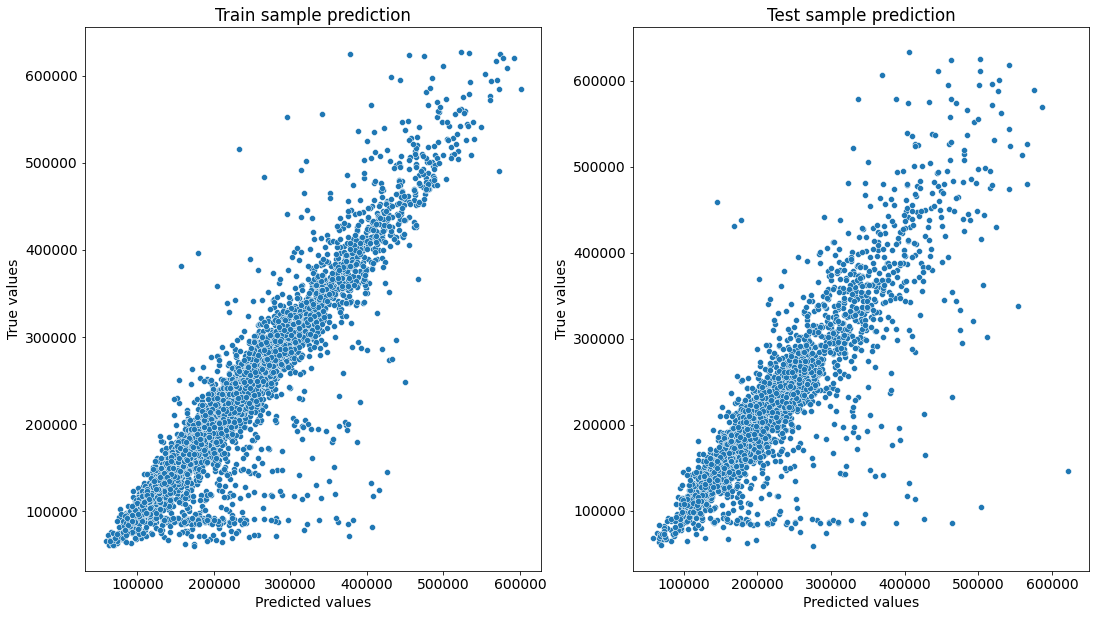

In [69]:
#evaluate_preds(y_train_sqm, y_train_sqm_preds, y_valid_sqm, y_valid_sqm_preds)
# evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)
evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [71]:
#cv_score.mean()
model

GradientBoostingRegressor(criterion='mse', learning_rate=0.025, loss='huber',
                          max_depth=6, max_features='sqrt', min_samples_leaf=50,
                          n_estimators=2250, random_state=21)

### важность признаков

In [72]:
feature_importances = pd.DataFrame(zip(X_train_for_model.columns,model.feature_importances_), columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
24,Square_log,0.189753
2,LifeSquare,0.164808
1,Rooms,0.118373
11,Social_1,0.070816
12,Social_2,0.068701
13,Social_3,0.068059
0,DistrictId,0.051458
7,Ecology_1,0.037137
23,MedPriceSQM_by_HA,0.032088
3,KitchenSquare,0.026289


In [73]:
# Итого
# экспериментировал с глубиной дерева после глубины выше 7 расетет переобучение, 
# результат на валидационнм датасете не увеличивается
# перепробовал разные модели и экспериментировал с регрессионными моделями (естественно делал масштабирование признаков) 
# результат примерно одинаковый.
# признак median_PriceSQM_by_DI_HY является для модели самым значимым, после его исключения качество предсказания сильно падает.
# Скорее всего нужно двигаться в направлении генерации признаков связанных с таргетом, которые бы помогали модели предсказывать
# целевую переменную.


#from sklearn.linear_model import LinearRegression

#lr = LinearRegression()
#gb = GradientBoostingRegressor()

#stack = StackingRegressor([('lr', lr), ('rf', rf_model)], final_estimator=gb)

In [74]:
5000/2**6

78.125

In [75]:
#stack.fit(X_train, y_train_sqm)

In [76]:
#y_train_sqm_preds = stack.predict(X_train)

In [77]:
#y_test_sqm_preds = stack.predict(X_valid)

In [78]:
#evaluate_preds(y_train_sqm, y_train_sqm_preds, y_valid_sqm, y_test_sqm_preds)

## Прогнозирование на тестовом датасете

In [79]:
df_test_for_model.shape

(5000, 25)

In [80]:
df_test_for_model.describe()

,DistrictId,Rooms,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Healthcare_1,...,Shops_1,Shops_2,median_room_square_by_DI_HY,LifeSquare_restored,LifeSquare_part,House_age,House_year_cat,MedPriceSQM_ByFloorYear,MedPriceSQM_by_HA,Square_log
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,51.279200,1.929600,33.349018,6.254600,7.529000,12.941600,1984.392600,0.119874,0.990400,997.997200,...,4.242800,0.917600,31.076334,0.370000,0.595910,36.607400,4.579200,3824.971881,3774.121718,3.983942
std,44.179466,0.802479,11.055982,2.781893,5.163186,6.466881,18.573149,0.120070,0.097518,1008.557242,...,4.777365,0.275001,6.958505,0.482853,0.075593,18.573149,1.464157,549.871257,766.160685,0.312798
min,0.000000,1.000000,9.495367,3.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,16.460000,0.000000,0.400000,1.000000,0.000000,2839.563468,2822.754331,2.792331
25%,21.000000,1.000000,25.360607,3.000000,4.000000,9.000000,1973.000000,0.019509,1.000000,145.000000,...,1.000000,1.000000,26.340000,0.000000,0.560000,21.000000,4.000000,3209.982179,2898.891745,3.735582
50%,37.000000,2.000000,32.136311,6.000000,6.000000,13.000000,1977.000000,0.072158,1.000000,750.000000,...,3.000000,1.000000,31.765000,0.000000,0.590000,44.000000,4.000000,4014.712071,4214.469102,3.968875
75%,77.000000,2.000000,38.326060,8.000000,11.000000,17.000000,2000.000000,0.195781,1.000000,1547.000000,...,6.000000,1.000000,33.910000,1.000000,0.660000,48.000000,6.000000,4155.148533,4394.917174,4.193966
max,212.000000,6.000000,197.432616,13.000000,46.000000,99.000000,2020.000000,0.521867,1.000000,4849.000000,...,23.000000,1.000000,168.090000,1.000000,0.880000,113.000000,7.000000,6766.013241,9377.231202,5.409204


In [81]:
#prediction_sqm = rf_model.predict(df_test_for_model)
prediction = model.predict(df_test_for_model)

In [82]:
prediction

array([176346.69054527, 124963.12634925, 140577.34496164, ...,
       156294.0747107 , 193599.89675132, 284037.59743111])

In [83]:
#prediction = prediction_sqm * df_test_for_model['Square'].values

In [84]:
submit = pd.read_csv(DS_SUBMIT_SAMPLE_PATH)

In [85]:
submit['Price'] = prediction
submit.head()

,Id,Price
0,4567,176346.690545
1,5925,124963.126349
2,960,140577.344962
3,3848,114948.147309
4,746,207147.208233


In [86]:
submit.to_csv(DS_SUBMIT_PATH, index=False)

In [87]:
#plt.scatter(X_train['DistrictSize'], y_train_sqm.values)

In [88]:
#plt.scatter(X_train['DistrictLarge'], y_train_sqm.values)